# Multiperiod Reports by Quarter in Beancount
If you've ever used [hledger](https://hledger.org/), you might like its ability to produce nice reports. One of the reports' feature is the table structure, where rows are accounts and columns are weeks, months, quarters or years. Looking at earnings and spendings as a function of time can give you more insights about your finances.

However, if you are using [beancount](http://furius.ca/beancount/), this feature is not yet supported in the command line interface. You need to use [fava](https://github.com/beancount/fava), an awesome web-interface for beancount, which has a graph drawing capability as described in this tutorial. fava is not ideal and sometimes you might need more custom reports than the ones available in fava.

This notebook provides methodology and tools to:
- Process BQL query's output using Pandas library
- Generate quarterly totals (multiperiod reports by quarter) by pivoting a table
- Aggregate values at different account levels for the provided account hierarchy
- Draw treemap plots of expenses for all time period

Details are in [this blog post](https://www.isabekov.pro/multiperiod-hledger-style-reports-in-beancount-pivoting-a-table/).

In [1]:
from beancount.loader import load_file
from beancount.query.query import run_query
from beancount.query.numberify import numberify_results
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_column', 15)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_seq_items',None)
pd.set_option('display.max_colwidth', 50000)
pd.set_option('display.width', 5000000)
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('precision', 2)
pd.set_option('expand_frame_repr', True)
import squarify
from matplotlib import pyplot as plt
font = {'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = (15, 5)

## Create and Load an Example Beancount Journal File

In [2]:
FileName = "example.beancount"
if not os.path.isfile(FileName):
    os.system("bean-example > {}".format(FileName))      
    
entries, _, opts = load_file(FileName)
currency = opts["operating_currency"][0]
# Main currency
currency

'USD'

## Investigating a Transaction

In [3]:
# Not all of the entries are transactions
len(entries)

2245

In [4]:
type(entries[-1])

beancount.core.data.Transaction

In [5]:
entries[-1].postings[0].account

'Assets:US:BofA:Checking'

In [6]:
entries[-1].postings[0].units

2832.14 USD

In [7]:
entries[-1].payee

'Hoogle'

In [8]:
entries[-1].narration

'Payroll'

## Executing a BQL Query

In [9]:
cols, rows = run_query(entries, opts, 
                       "SELECT   account,   YEAR(date) AS year,\
                                 MONTH(date) as month,\
                                 SUM(convert(position, '{}', date)) AS amount\
                        WHERE    account ~ 'Expenses'\
                        OR       account ~ 'Income'\
                        GROUP BY account, year, month\
                        ORDER BY account, year, month".format(currency)
                      )
cols

[('account', str),
 ('year', int),
 ('month', int),
 ('amount', beancount.core.inventory.Inventory)]

In [10]:
rows[:3]

[ResultRow(account='Expenses:Financial:Commissions', year=2018, month=10, amount=(44.75 USD)),
 ResultRow(account='Expenses:Financial:Commissions', year=2018, month=11, amount=(35.80 USD)),
 ResultRow(account='Expenses:Financial:Commissions', year=2018, month=12, amount=(35.80 USD))]

In [11]:
cols, rows = numberify_results(cols, rows)
cols

[('account', str),
 ('year', int),
 ('month', int),
 ('amount (USD)', decimal.Decimal),
 ('amount (VACHR)', decimal.Decimal),
 ('amount (IRAUSD)', decimal.Decimal)]

In [12]:
rows[:3]

[['Expenses:Financial:Commissions', 2018, 10, Decimal('44.75'), None, None],
 ['Expenses:Financial:Commissions', 2018, 11, Decimal('35.80'), None, None],
 ['Expenses:Financial:Commissions', 2018, 12, Decimal('35.80'), None, None]]

## Converting Result Rows to a Pandas Dataframe

In [13]:
df = pd.DataFrame(rows, columns=[k[0] for k in cols])
df.head()

,account,year,month,amount (USD),amount (VACHR),amount (IRAUSD)
0,Expenses:Financial:Commissions,2018,10,44.75,None,None
1,Expenses:Financial:Commissions,2018,11,35.80,None,None
2,Expenses:Financial:Commissions,2018,12,35.80,None,None
3,Expenses:Financial:Commissions,2019,5,35.80,None,None
4,Expenses:Financial:Commissions,2019,6,8.95,None,None


In [14]:
df.rename(columns={"account": "Account", "year":"Year", "month": "Month", "amount ({})".format(currency): "Amount ({})".format(currency)}, inplace=True)
df.dtypes

Account            object
Year                int64
Month               int64
Amount (USD)       object
amount (VACHR)     object
amount (IRAUSD)    object
dtype: object

In [15]:
df = df.astype({"Account": str, "Year": int, "Month": int, "Amount ({})".format(currency): np.float})
df = df[["Account", "Year", "Month", "Amount ({})".format(currency)]].fillna(0)
df.head()

,Account,Year,Month,Amount (USD)
0,Expenses:Financial:Commissions,2018,10,44.75
1,Expenses:Financial:Commissions,2018,11,35.80
2,Expenses:Financial:Commissions,2018,12,35.80
3,Expenses:Financial:Commissions,2019,5,35.80
4,Expenses:Financial:Commissions,2019,6,8.95


In [16]:
df["YearMonth"] = df.apply(lambda x: "{}-{:0>2d}".format(x["Year"], x["Month"]),axis=1)
df = df[["Account", "YearMonth", "Amount ({})".format(currency)]]
df.head()

,Account,YearMonth,Amount (USD)
0,Expenses:Financial:Commissions,2018-10,44.75
1,Expenses:Financial:Commissions,2018-11,35.80
2,Expenses:Financial:Commissions,2018-12,35.80
3,Expenses:Financial:Commissions,2019-05,35.80
4,Expenses:Financial:Commissions,2019-06,8.95


In [17]:
df.index = pd.to_datetime(df["YearMonth"], format='%Y-%m') + pd.offsets.MonthEnd(0)
df.drop(columns="YearMonth", inplace=True)
df.head()

,Account,Amount (USD)
YearMonth,,
2018-10-31,Expenses:Financial:Commissions,44.75
2018-11-30,Expenses:Financial:Commissions,35.80
2018-12-31,Expenses:Financial:Commissions,35.80
2019-05-31,Expenses:Financial:Commissions,35.80
2019-06-30,Expenses:Financial:Commissions,8.95


In [18]:
# Aggregate at quarter level
df = df.groupby(["Account", pd.Grouper(freq='Q')]).sum()
df.index.rename(names = ["Account", "Quarter"], inplace=True)
df.head(20)

Amount (USD)
Account                        Quarter                 
Expenses:Financial:Commissions 2018-12-31        116.35
                               2019-06-30         44.75
                               2019-09-30         71.60
                               2019-12-31          8.95
                               2020-06-30         98.45
                               2020-09-30         62.65
                               2020-12-31         71.60
Expenses:Financial:Fees        2018-03-31         12.00
                               2018-06-30         12.00
                               2018-09-30         12.00
                               2018-12-31         12.00
                               2019-03-31         12.00
                               2019-06-30         12.00
                               2019-09-30         12.00
                               2019-12-31         12.00
                               2020-03-31         12.00
                               2020-06-30         12.00
                               2020-09-30         12.00
                               2020-12-31         12.00
Expenses:Food:Coffee           2018-06-30          5.49

## Pivoting a Table by Quarter

In [19]:
df = df.pivot_table(index="Account", columns=df.index.get_level_values(1).map(lambda s: s.strftime('%Y-%m')).astype('period[Q]').strftime('%F-Q%q')).fillna(0).reset_index()
df.head()

Account Amount (USD)                                                                                                
Quarter                                      2018-Q1 2018-Q2  2018-Q3  2018-Q4 2019-Q1  2019-Q2  2019-Q3  2019-Q4  2020-Q1  2020-Q2  2020-Q3 2020-Q4
0        Expenses:Financial:Commissions         0.00    0.00     0.00   116.35    0.00    44.75    71.60     8.95     0.00    98.45    62.65   71.60
1               Expenses:Financial:Fees        12.00   12.00    12.00    12.00   12.00    12.00    12.00    12.00    12.00    12.00    12.00   12.00
2                  Expenses:Food:Coffee         0.00    5.49     0.00     0.00    0.00     0.00    36.76     0.00     0.00     0.00    43.07    0.00
3               Expenses:Food:Groceries       582.97  559.27   616.30   540.30  480.78   722.67   520.40   641.20   711.49   581.02   442.03  557.04
4              Expenses:Food:Restaurant       948.18  948.24  1139.92  1027.88  983.15  1127.47  1780.95  1064.27  1109.25  1143.04  1214.80  933.98

## Creating Multi-Level Accounts

In [20]:
n_levels = df["Account"].str.count(":").max() + 1
n_levels

6

In [21]:
cols = ["Account_L{}".format(k) for k in range(n_levels)]
cols

['Account_L0',
 'Account_L1',
 'Account_L2',
 'Account_L3',
 'Account_L4',
 'Account_L5']

In [22]:
df[cols] = df["Account"].str.split(':', n_levels - 1, expand=True)
df = df.fillna('').drop(columns="Account", level=0).set_index(cols)
df.head()

Amount (USD)                                                                                                
Quarter                                                                 2018-Q1 2018-Q2  2018-Q3  2018-Q4 2019-Q1  2019-Q2  2019-Q3  2019-Q4  2020-Q1  2020-Q2  2020-Q3 2020-Q4
Account_L0 Account_L1 Account_L2  Account_L3 Account_L4 Account_L5                                                                                                             
Expenses   Financial  Commissions                                          0.00    0.00     0.00   116.35    0.00    44.75    71.60     8.95     0.00    98.45    62.65   71.60
                      Fees                                                12.00   12.00    12.00    12.00   12.00    12.00    12.00    12.00    12.00    12.00    12.00   12.00
           Food       Coffee                                               0.00    5.49     0.00     0.00    0.00     0.00    36.76     0.00     0.00     0.00    43.07    0.00
                      Groceries                                          582.97  559.27   616.30   540.30  480.78   722.67   520.40   641.20   711.49   581.02   442.03  557.04
                      Restaurant                                         948.18  948.24  1139.92  1027.88  983.15  1127.47  1780.95  1064.27  1109.25  1143.04  1214.80  933.98

## Aggregation at Different Account Levels

In [23]:
df_L1 = df.groupby(["Account_L0", "Account_L1"]).sum()
df_L1.style.set_table_styles(
[{'selector': 'tr:hover',
  'props': [('background-color', 'yellow')]}]
)

In [24]:
df_L0 = df.groupby(["Account_L0"]).sum()
df_L0.style.set_table_styles(
[{'selector': 'tr:hover',
  'props': [('background-color', 'yellow')]}]
)

In [25]:
# Net income
-df_L0.sum(axis=0).to_frame().rename(columns={0: "Net income"}).transpose()

Amount (USD)                                                                                                      
Quarter         2018-Q1  2018-Q2  2018-Q3  2018-Q4   2019-Q1  2019-Q2  2019-Q3  2019-Q4   2020-Q1  2020-Q2  2020-Q3   2020-Q4
Net income     12347.85  9208.02  9385.93  5878.49  11561.92  8745.19  9072.07  5824.03  11220.09  9794.65  9517.22  11507.71

In [26]:
# Invert the sign of the "Income" account. Negative income is counter-intuitive.
df_L0.loc["Income"] = -df_L0.loc["Income"]
df_L0 = df_L0.transpose().reset_index()
df_L0

Account_L0,level_0,Quarter,Expenses,Income
0,Amount (USD),2018-Q1,24330.05,36677.90
1,Amount (USD),2018-Q2,22230.18,31438.20
2,Amount (USD),2018-Q3,24541.97,33927.90
3,Amount (USD),2018-Q4,22077.49,27955.98
4,Amount (USD),2019-Q1,25166.88,36728.80
5,Amount (USD),2019-Q2,22623.04,31368.23
6,Amount (USD),2019-Q3,25106.28,34178.35
7,Amount (USD),2019-Q4,22129.43,27953.46
8,Amount (USD),2020-Q1,25573.07,36793.16
9,Amount (USD),2020-Q2,22548.52,32343.17


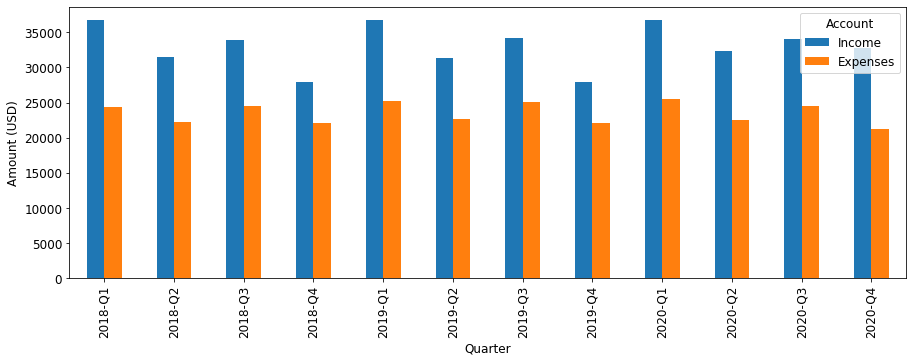

In [27]:
df_L0.columns.name = "Account"
df_L0.plot.bar(x="Quarter", y=["Income", "Expenses"], xlabel="Quarter", ylabel=df_L0["level_0"][0], rot=90)
plt.show()

## Treemap Plot of Expenses

In [28]:
tot = df_L1.sum(axis=1).to_frame().sort_values(by=0, ascending=False)
tot

0
Account_L0 Account_L1           
Expenses   Taxes       157987.98
           Home         91173.19
           Food         20461.92
           Health        7655.10
           Transport     4200.00
           Financial      618.35
           Vacation         0.00
Income     US         -396159.71

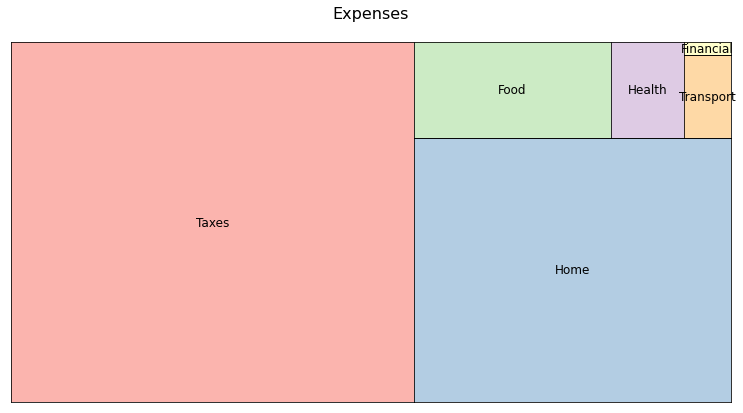

In [29]:
data = tot.loc["Expenses"].sort_values(by=0, ascending=False)
idx = [k[0] != 0 for k in data.values]
values = data.values[idx]
labels = data.index[idx]

width = 1
height = 0.5
values_norm = squarify.normalize_sizes(values, width, height)
rects = squarify.squarify(values_norm, 0, 0, width, height)

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Expenses', x=0.5, y=0.55, fontsize=16)
axes = [fig.add_axes([rect['x'], rect['y'], rect['dx'], rect['dy'], ]) for rect in rects]

for ax, txt, color in zip(axes, labels, plt.cm.Pastel1.colors):
    ax.text(0.5, 0.5, txt, horizontalalignment='center', verticalalignment='center')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_facecolor(color)    
plt.show()